In [1]:
import sys,os
from pathlib import Path

def add_dependencies():
    add_path = lambda path: sys.path.append(str(path))
    root_folder = Path(os.getcwd()).parent
    cryoem_folder = Path(root_folder, 'cryoem')
    cython_folder = Path(root_folder,'cryoem-cython-pyx')

    add_path(root_folder)
    add_path(cryoem_folder)
    add_path(Path(cryoem_folder,'util'))
    add_path(Path(cython_folder,'sincint'))
    add_path(Path(cython_folder,'sparsemul'))

add_dependencies()

In [2]:
import time

import numpy as np
import numpy.fft as fourier

import matplotlib as mpl
import matplotlib.pyplot as plt

from cryoem.cryoio import ctf, mrc
from cryoem.util import format_timedelta
from cryoem import geom, cryoops, density
import sincint


mpl.rcParams['figure.dpi'] = 300
plt.style.use(['dark_background'])

ERROR LOADING FFTW! USING NUMPY


In [3]:
defocus_min = 10000
defocus_max = 20000
defocus_ang_min = 0
defocus_ang_max = 360
accel_kv = 300
amp_contrast = 0.07
phase_shift = 0
scale = 1
spherical_abberr = 2.7
mag = 10000.0

n_particles = 10
n_gridpoints = 8
snr = 0.05

kernel = 'lanczos'
ksize = int(6)
rad = 0.95
shift_sigma = 0
bfactor = 50.0

In [4]:
# Read the volume data and compute fft
vol,hdr = mrc.readMRC("../data/cav_3d.mrc", inc_header=True)
# vol,hdr = mrc.readMRC("test_data/6ac9TeMet_denmod.mrc", inc_header=True)

boxSize = int(vol.shape[0])
pxSize = (hdr['xlen']/hdr['nx'])

premult = cryoops.compute_premultiplier(boxSize, kernel, ksize) 

V = density.real_to_fspace(premult.reshape((1,1,-1)) * premult.reshape((1,-1,1)) * premult.reshape((-1,1,1)) * vol)

vol_f = fourier.fftshift(fourier.fft2(vol))

# plt.imshow(np.abs(vol[154,:,:]))
# sigma_noise = vol.std()/snr
# print('Noise sigma: ' + str(sigma_noise))
# plt.savefig('read_vol.png')

vol.max()

np.float32(39.041557)

In [5]:
particle_metadata = [{} for _ in range(n_particles)]
particles = np.empty((n_particles, boxSize, boxSize), dtype=density.real_t)
starfile = []
TtoF = sincint.gentrunctofull(N=boxSize, rad=rad)

ctfed = []
noised = []
fspace = []

tic = time.time()
for i,p in enumerate(particle_metadata):
    ellapse_time = time.time() - tic
    remain_time = float(n_particles - i)*ellapse_time/max(i,1)
    print("\r%.2f Percent Complete (%d particles done)... (Elapsed: %s, Remaining: %s)" % (i/float(n_particles)*100.0,i,format_timedelta(ellapse_time),format_timedelta(remain_time)), end="")
    
    # GENERATE PARTICLE ORIENTATION AND CTF PARAMETERS
    # Random orientation vector and get spherical angles
    pt = np.random.randn(3)
    pt /= np.linalg.norm(pt)
    psi = 2*np.pi*np.random.rand()
    
    # Compute Euler angles from a direction vector. Output EA is tuple with phi, theta, psi.
    EA = geom.genEA(pt)[0]
    EA[2] = psi
    
    p['phi'] = EA[0]*180.0/np.pi
    p['theta'] = EA[1]*180.0/np.pi
    p['psi'] = EA[2]*180.0/np.pi
    
    # Compute a random shift
    shift = np.random.randn(2) * shift_sigma
    p['shift_x'] = shift[0]
    p['shift_y'] = shift[1]
    
    # Random defocus within the ranges
    base_defocus = np.random.uniform(defocus_min, defocus_max)
    p['defocus_a'] = base_defocus + np.random.uniform(-500,500)
    p['defocus_b'] = base_defocus + np.random.uniform(-500,500)
    p['astig_angle'] = np.random.uniform(defocus_ang_min, defocus_ang_max)
    
    # CREATE THE PROJECTIONS AND APPLY CTFS
    # Generate rotation matrix based on the Euler Angles
    R = geom.rotmat3D_EA(*EA)[:,0:2]
    slop = cryoops.compute_projection_matrix([R], boxSize, kernel, ksize, rad, 'rots')
    S = cryoops.compute_shift_phases(shift.reshape((1,2)), boxSize, rad)[0]
    D = slop.dot(V.reshape((-1,)))
    D *= S
      
    # Generate the CTF
    C = ctf.compute_full_ctf(None, boxSize, pxSize, accel_kv, spherical_abberr, amp_contrast, p['defocus_a'], p['defocus_b'], np.radians(p['astig_angle']), 1, bfactor)
    particles[i] = density.fspace_to_real((TtoF.dot(D)).reshape((boxSize,boxSize)))
    fspace.append(D)
    # Apply CTF to the projection and write to particles array
    ctf_distorted = density.fspace_to_real((C*TtoF.dot(D)).reshape((boxSize,boxSize)))
    ctfed.append(ctf_distorted)
    noise_added = ctf_distorted + np.require(np.random.randn(boxSize, boxSize)*10,dtype=density.real_t)
    noised.append(-noise_added)
    
    starfile_line = [str(amp_contrast), 
                     str(p['psi']), 
                     str(p['phi']), 
                     str(p['theta']),
                     str(1),
                     str(p['astig_angle']),                     
                     str(p['defocus_a']),
                     str(p['defocus_b']),
                     str(pxSize),
                     "%d@/simulated_particles.mrcs" % (i+1),
                     str(mag),
                     str(0),
                     str(0),
                     str(0),
                     str(spherical_abberr),
                     str(accel_kv)]
    starfile.append(starfile_line)
                          

90.00 Percent Complete (9 particles done)... (Elapsed: 00:00:00s, Remaining: 00:00:00s)

In [ ]:
output_folder = Path('..','output')
output_folder.mkdir(exist_ok=True)

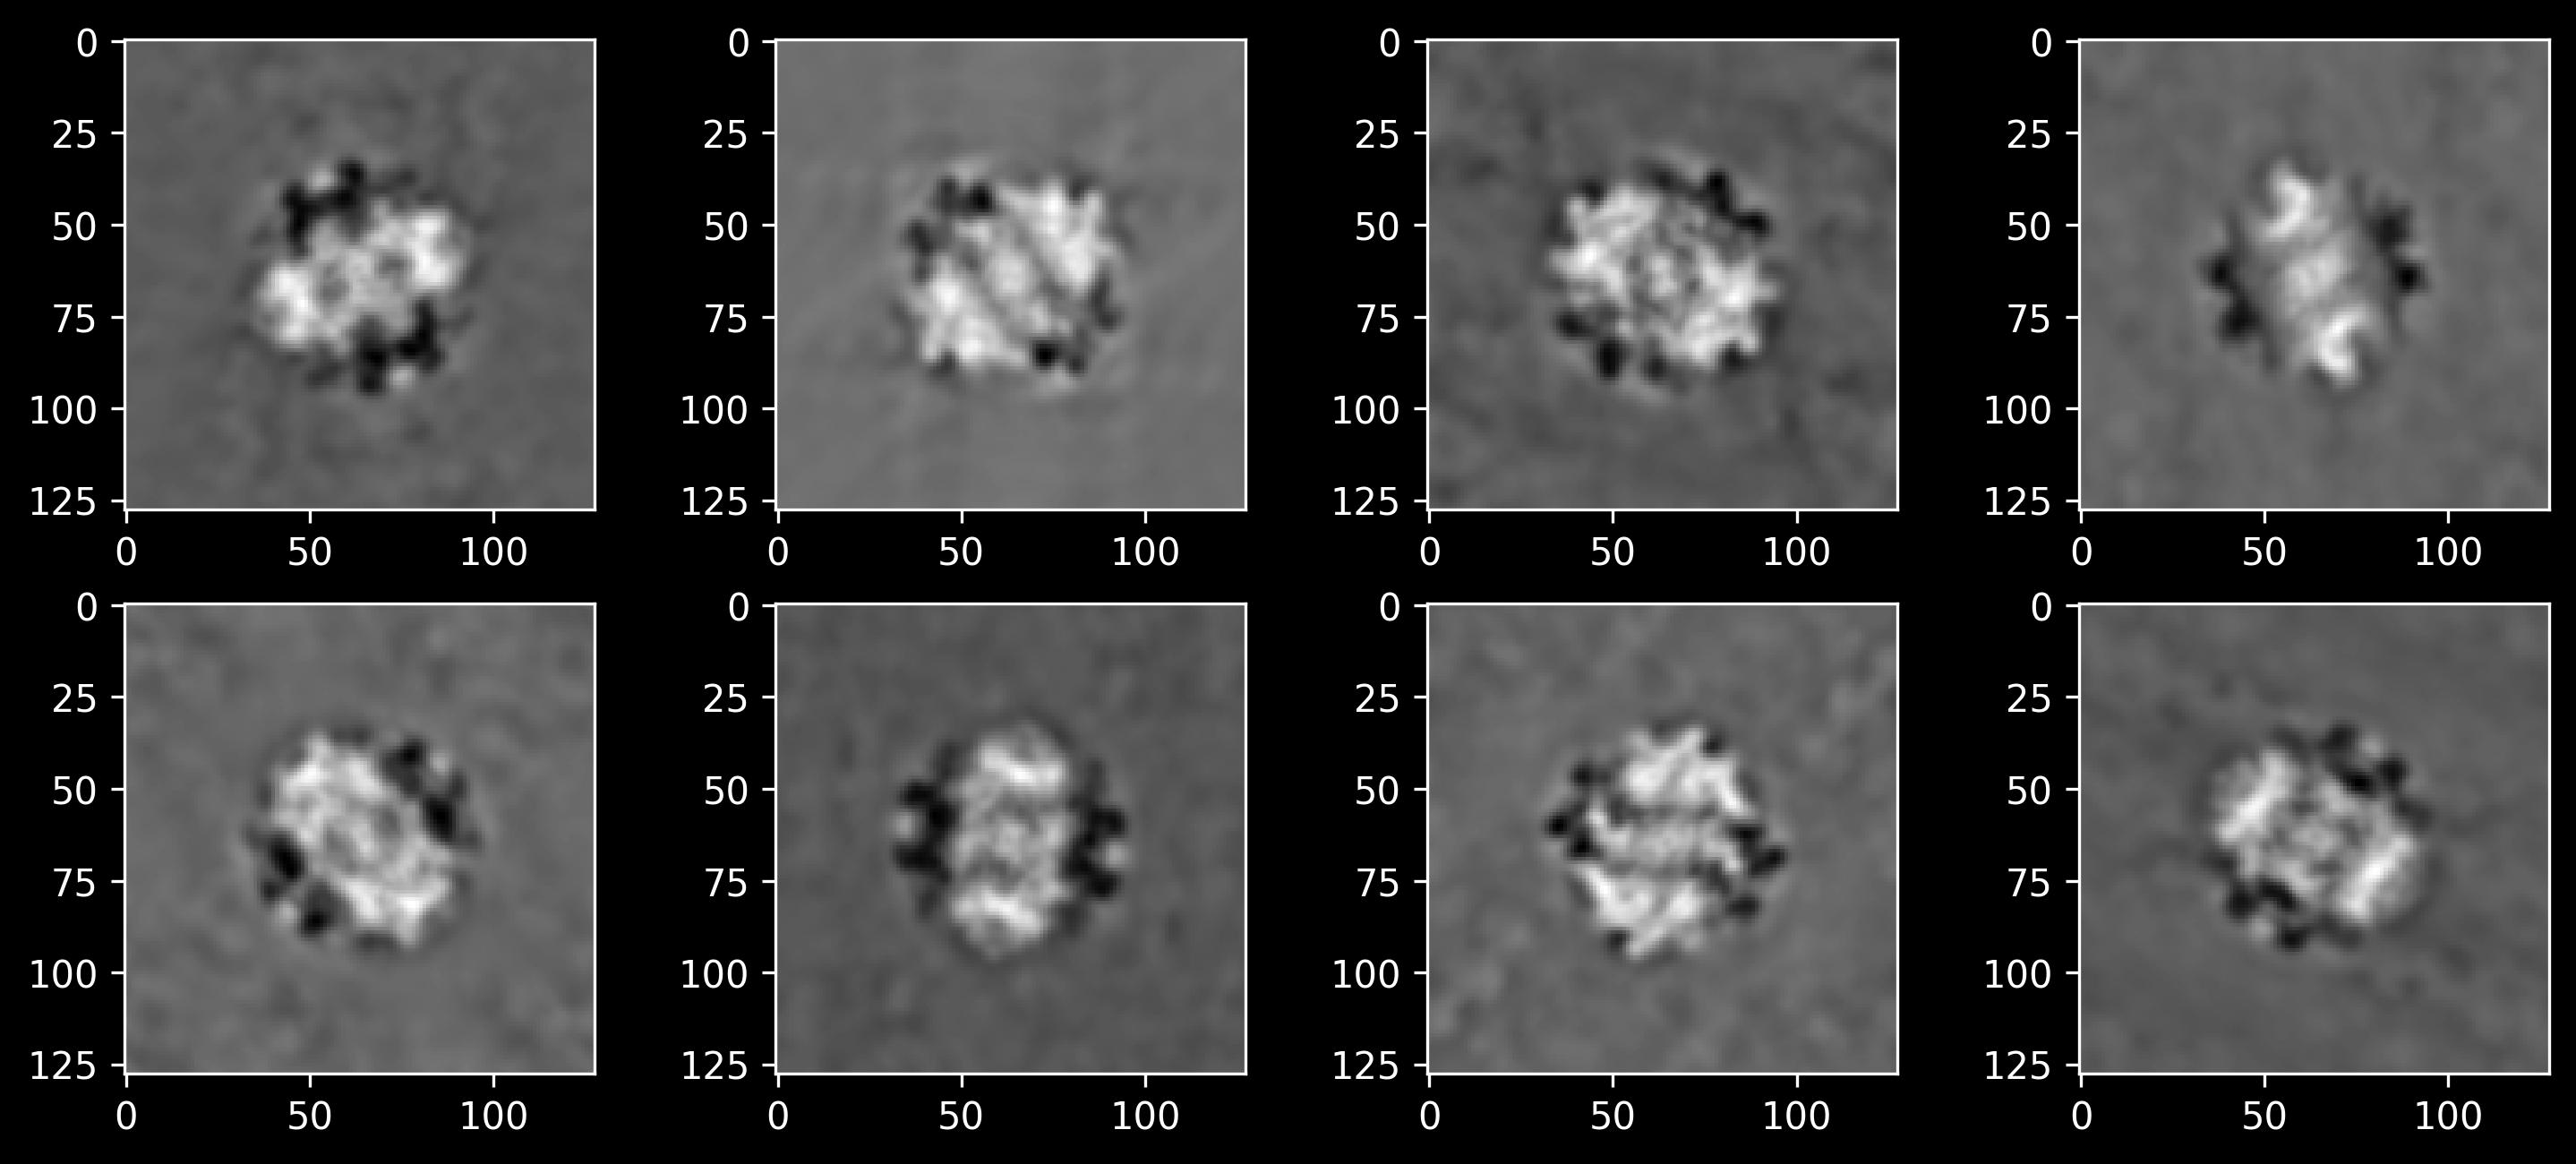

In [6]:
# Plot the first 8 images
fig = plt.figure(figsize=(12, 5))
col = 4
row = 2
for i in range(1, col*row +1):
    img = particles[i]
    fig.add_subplot(row, col, i)
    plt.imshow(img, cmap='gray')
plt.savefig(Path(output_folder,'projections.png'))
plt.show()


In [7]:
# Write the particle stack
mrc.writeMRC(Path(output_folder,'simulated_particles.mrcs'), np.transpose(particles,(1,2,0)), pxSize)

In [8]:
# Write the starfile
with open(Path(output_folder,'simulated_particles.star'), 'w') as f:
    # Write the header
    f.write("\ndata_images\n\nloop_\n_rlnAmplitudeContrast #1 \n_rlnAnglePsi #2 \n_rlnAngleRot #3 \n_rlnAngleTilt #4 \n_rlnClassNumber #5 \n_rlnDefocusAngle #6 \n_rlnDefocusU #7 \n_rlnDefocusV #8 \n_rlnDetectorPixelSize #9 \n_rlnImageName #10 \n_rlnMagnification #11 \n_rlnOriginX #12 \n_rlnOriginY #13 \n_rlnPhaseShift #14 \n_rlnSphericalAberration #15\n_rlnVoltage #16\n\n")
    # Write the particle information
    for l in starfile:
        f.write(' '.join(l) + '\n')